In [21]:
import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope



In [3]:
# Wczytanie i przygotowanie danych
data = loadmat('../datasets/cover.mat')
X = data['X']
y = data['y'].ravel()

# Podział na inliers i outliers
X_inliers = X[y == 0]
X_outliers = X[y == 1]

# Podział inliers na zbiór treningowy i testowy
X_train, X_test = train_test_split(X_inliers, test_size=0.2, random_state=42)
X_ood = X_outliers




In [4]:
# Standaryzacja względem danych treningowych
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_ood_scaled = scaler.transform(X_ood)

## LOF

In [5]:
# Strojenie parametru n_neighbors
n_neighbors_list = [5, 10, 20, 35, 50]
best_auc = 0
best_n = None

for n in n_neighbors_list:
    # Trenowanie modelu na danych treningowych (tylko inliers)
    model = LocalOutlierFactor(n_neighbors=n, novelty=True)
    model.fit(X_train_scaled)
    
    # Obliczenie score'ów dla wszystkich zbiorów
    train_scores = model.score_samples(X_train_scaled)
    test_scores = model.score_samples(X_test_scaled)
    ood_scores = model.score_samples(X_ood_scaled)
    
    # Przygotowanie danych do obliczenia AUC
    combined_scores = np.concatenate([test_scores, ood_scores])
    combined_labels = np.concatenate([np.zeros(len(test_scores)), np.ones(len(ood_scores))])
    
    # Obliczenie AUC (im niższy score, tym bardziej anomalny)
    auc = roc_auc_score(combined_labels, -combined_scores)  # Negujemy score
    
    print(f'n_neighbors={n}: AUC={auc:.3f}')
    
    if auc > best_auc:
        best_auc = auc
        best_n = n
        best_train_scores = train_scores
        best_test_scores = test_scores
        best_ood_scores = ood_scores

n_neighbors=5: AUC=0.970
n_neighbors=10: AUC=0.982
n_neighbors=20: AUC=0.989
n_neighbors=35: AUC=0.992
n_neighbors=50: AUC=0.992


C:\Users\Radosz\AppData\Local\Temp\ipykernel_17884\4195350227.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(


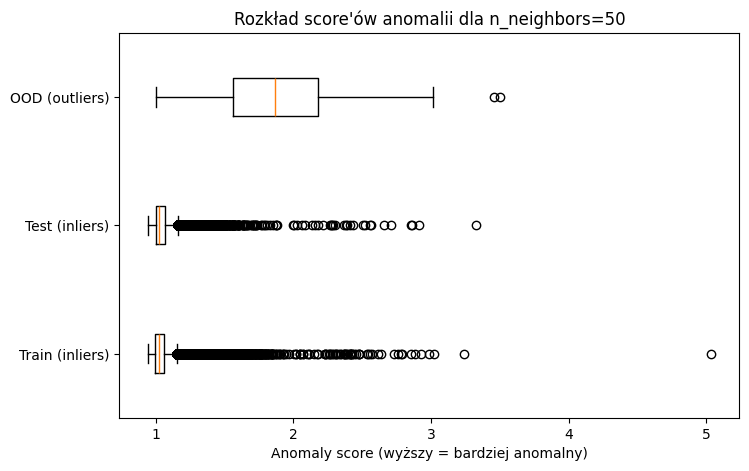

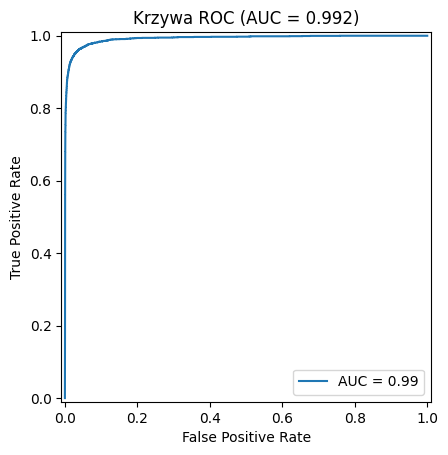


Najlepsze parametry: n_neighbors=50
AUC: 0.992
Optymalny próg: 1.008
TPR przy optymalnym progu: 0.960
FPR przy optymalnym progu: 0.036


In [6]:
# Wykres pudełkowy dla najlepszego modelu
fig, ax = plt.subplots(figsize=(8, 5))
ax.boxplot(
    [-best_train_scores, -best_test_scores, -best_ood_scores],  # Negujemy dla interpretacji "im wyższy = bardziej anomalny"
    labels=['Train (inliers)', 'Test (inliers)', 'OOD (outliers)'],
    vert=False
)
ax.set_title(f'Rozkład score\'ów anomalii dla n_neighbors={best_n}')
ax.set_xlabel('Anomaly score (wyższy = bardziej anomalny)')
plt.show()

# Krzywa ROC dla najlepszego modelu
combined_scores = np.concatenate([best_test_scores, best_ood_scores])
combined_labels = np.concatenate([np.zeros(len(best_test_scores)), np.ones(len(best_ood_scores))])
fpr, tpr, _ = roc_curve(combined_labels, -combined_scores)  # Używamy negowanych score'ów

RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=best_auc).plot()
plt.title(f'Krzywa ROC (AUC = {best_auc:.3f})')
plt.show()

# Optymalny próg (Youden's J-statistic)
youden_idx = np.argmax(tpr - fpr)
optimal_threshold = -combined_scores[youden_idx]  # Ponieważ używaliśmy negowanych score'ów

print(f'\nNajlepsze parametry: n_neighbors={best_n}')
print(f'AUC: {best_auc:.3f}')
print(f'Optymalny próg: {optimal_threshold:.3f}')
print(f'TPR przy optymalnym progu: {tpr[youden_idx]:.3f}')
print(f'FPR przy optymalnym progu: {fpr[youden_idx]:.3f}')

# Mahalanobis

Średnie score'y:
Train: -24.653
Test:  -27.795
OOD:   -64.586


C:\Users\Radosz\AppData\Local\Temp\ipykernel_17884\621415044.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


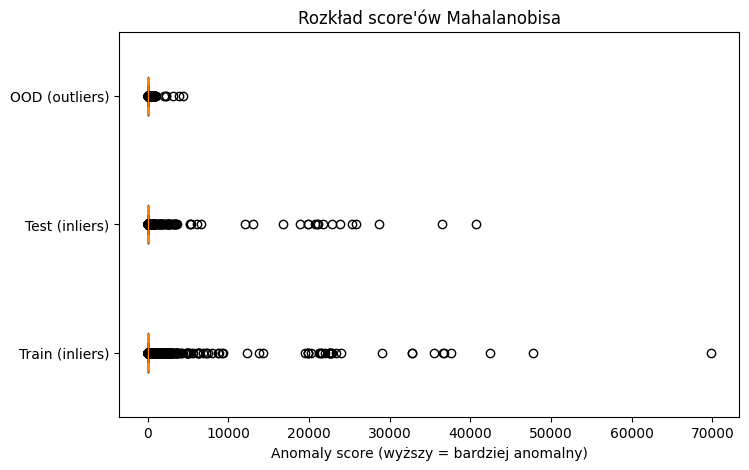

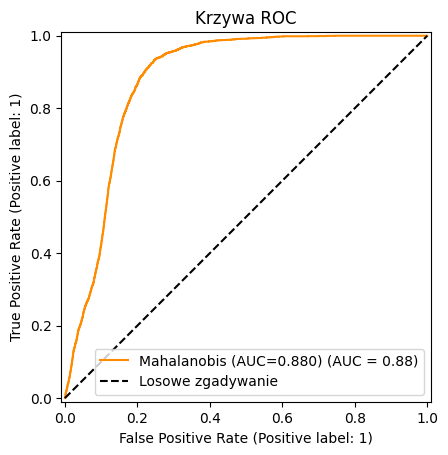

In [ ]:
# Strojenie parametrów
best_auc = 0
params_grid = {
    'support_fraction': [0.5, 0.7, 0.9],
    'contamination': [1e-9, 0.01]  # 0.0 jeśli zakładamy czyste dane treningowe
}

# Pełna siatka parametrów (dla uproszczenia pokazuję pojedynczą iterację)
for sf in params_grid['support_fraction']:
    for cont in params_grid['contamination']:
        # Inicjalizacja i trening
        model = EllipticEnvelope(
            support_fraction=sf,
            contamination=cont,
            random_state=42
        )
        model.fit(X_train_scaled)
        
        # Obliczenie score'ów
        train_scores = model.score_samples(X_train_scaled)
        test_scores = model.score_samples(X_test_scaled)
        ood_scores = model.score_samples(X_ood_scaled)
        
        # Obliczenie AUC
        combined_scores = np.concatenate([test_scores, ood_scores])
        combined_labels = np.concatenate([np.zeros_like(test_scores), np.ones_like(ood_scores)])
        auc = roc_auc_score(combined_labels, -combined_scores)
        
        # Aktualizacja najlepszego modelu
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_scores = {
                'train': train_scores,
                'test': test_scores,
                'ood': ood_scores
            }

# Analiza najlepszego modelu
print("Średnie score'y:")
print(f"Train: {np.mean(best_scores['train']):.3f}")
print(f"Test:  {np.mean(best_scores['test']):.3f}")
print(f"OOD:   {np.mean(best_scores['ood']):.3f}")

# Wykres pudełkowy
plt.figure(figsize=(8, 5))
plt.boxplot(
    [-best_scores['train'], -best_scores['test'], -best_scores['ood']],  # Negacja dla spójnej interpretacji
    labels=['Train (inliers)', 'Test (inliers)', 'OOD (outliers)'],
    vert=False
)
plt.title("Rozkład score'ów Mahalanobisa")
plt.xlabel("Anomaly score (wyższy = bardziej anomalny)")
plt.show()

# Krzywa ROC
XX = np.concatenate([X_test_scaled, X_ood_scaled], axis=0)
yy = [0]*len(X_test_scaled) + [1]*len(X_ood_scaled)
yy_score = -best_model.decision_function(XX)  # Używamy decision_function zamiast score_samples

RocCurveDisplay.from_predictions(
    yy,
    yy_score,
    name=f"Mahalanobis (AUC={best_auc:.3f})",
    color="darkorange"
)
plt.plot([0, 1], [0, 1], "k--", label="Losowe zgadywanie")
plt.title("Krzywa ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Isolation Forest

Najlepsze parametry: {'n_estimators': 50, 'max_samples': 0.5, 'contamination': 1e-09}
AUC: 0.987

Średnie score'y:
Train: -0.424
Test:  -0.424
OOD:   -0.556


C:\Users\Radosz\AppData\Local\Temp\ipykernel_17884\4210076108.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


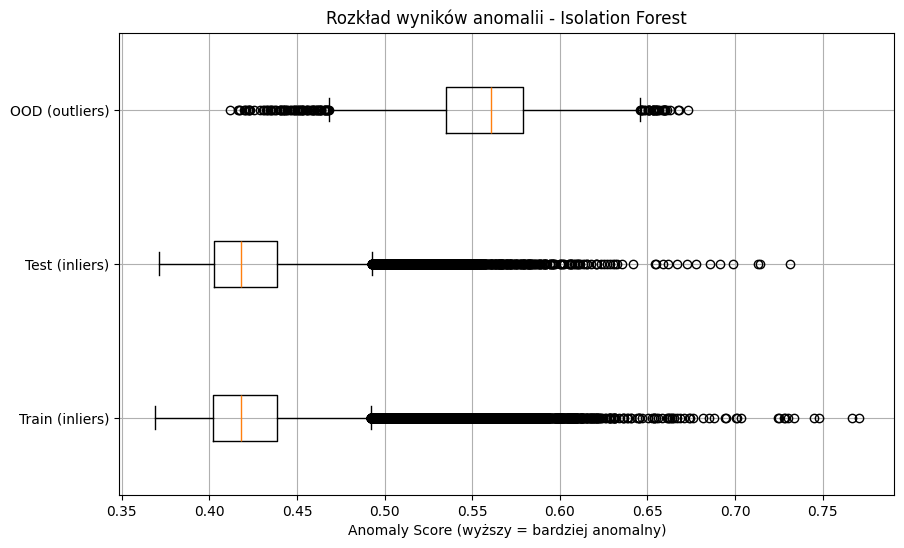

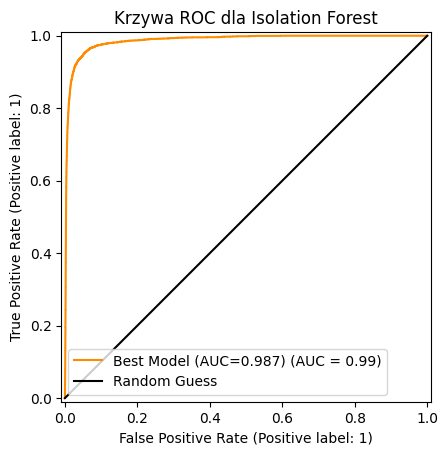


Optymalny punkt:
FPR: 0.055
TPR: 0.954


In [23]:
# Strojenie parametrow (dostosuj zakresy do swoich danych)
params_grid = {
    'n_estimators': [50, 100, 200],
    'max_samples': [0.5, 0.7, 0.9],
    'contamination': [1e-9, 0.1, 0.2]
}

best_auc = 0
best_params = {}

for n in params_grid['n_estimators']:
    for s in params_grid['max_samples']:
        for c in params_grid['contamination']:
            model = IsolationForest(
                n_estimators=n,
                max_samples=s,
                contamination=c,
                random_state=42
            )
            model.fit(X_train_scaled)
            
            # Ocena na test i OOD
            test_scores = model.score_samples(X_test_scaled)
            ood_scores = model.score_samples(X_ood_scaled)
            
            # Obliczenie AUC
            scores = np.concatenate([test_scores, ood_scores])
            labels = np.concatenate([np.zeros_like(test_scores), np.ones_like(ood_scores)])
            auc = roc_auc_score(labels, -scores)
            
            if auc > best_auc:
                best_auc = auc
                best_params = {'n_estimators': n, 'max_samples': s, 'contamination': c}
                best_model = model

# Wyniki dla najlepszego modelu
train_scores = best_model.score_samples(X_train_scaled)
test_scores = best_model.score_samples(X_test_scaled)
ood_scores = best_model.score_samples(X_ood_scaled)

print(f"Najlepsze parametry: {best_params}")
print(f"AUC: {best_auc:.3f}")
print("\nŚrednie score'y:")
print(f"Train: {np.mean(train_scores):.3f}")
print(f"Test:  {np.mean(test_scores):.3f}")
print(f"OOD:   {np.mean(ood_scores):.3f}")

# Wykres pudełkowy
plt.figure(figsize=(10, 6))
plt.boxplot(
    [-train_scores, -test_scores, -ood_scores],
    labels = ['Train (inliers)', 'Test (inliers)', 'OOD (outliers)'],
    vert = False
)
plt.title("Rozkład wyników anomalii - Isolation Forest")
plt.xlabel("Anomaly Score (wyższy = bardziej anomalny)")
plt.grid(True)
plt.show()

# Krzywa ROC
combined_scores = np.concatenate([test_scores, ood_scores])
labels = np.concatenate([np.zeros_like(test_scores), np.ones_like(ood_scores)])

RocCurveDisplay.from_predictions(
    labels,
    -combined_scores,
    name=f"Best Model (AUC={best_auc:.3f})",
    color="darkorange"
)
plt.plot([0, 1], [0, 1], "k-", label="Random Guess")
plt.legend()
plt.title("Krzywa ROC dla Isolation Forest")
plt.show()

# Optymalny punkt na krzywej ROC (Youden's J)
fpr, tpr, _ = roc_curve(labels, -combined_scores)
youden_idx = np.argmax(tpr - fpr)
print(f"\nOptymalny punkt:")
print(f"FPR: {fpr[youden_idx]:.3f}")
print(f"TPR: {tpr[youden_idx]:.3f}")